<a href="https://colab.research.google.com/github/RenukaSiriwardhana/Skin-Cancer-Detection--DermaVision/blob/main/notebooks/implementation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/DermaVision/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured...")

Kaggle API configured...


In [15]:
import os

DRIVE_ZIP_PATH = "/content/drive/MyDrive/DermaVision/dataset_cache/ham10000-split-and-augmented.zip"
EXTRACT_PATH = "/content/ham10000_dataset"

os.makedirs("/content/drive/MyDrive/DermaVision/dataset_cache", exist_ok=True)

if not os.path.exists(DRIVE_ZIP_PATH):
    print("Downloading dataset from Kaggle (one time only)...")
    !kaggle datasets download -d ahefatresearch/ham10000-split-and-augmented -p /content --force
    !cp /content/ham10000-split-and-augmented.zip "{DRIVE_ZIP_PATH}"
    print("Dataset zip saved to Drive ")
else:
    print("Dataset already exists in Drive (Skipping download)")

Dataset URL: https://www.kaggle.com/datasets/ahefatresearch/ham10000-split-and-augmented
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 2.85G/2.87G [00:23<00:00, 245MB/s]
100% 2.87G/2.87G [00:23<00:00, 132MB/s]
Dataset zip saved to Drive 


In [16]:
!rm -rf "{EXTRACT_PATH}"
!unzip -q "{DRIVE_ZIP_PATH}" -d "{EXTRACT_PATH}"

print("Extracted dataset folders:")
!ls "{EXTRACT_PATH}"

Extracted dataset folders:
test_dir  train_dir  val_dir


In [17]:
import os

BASE_DIR = "/content/ham10000_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train_dir")
TEST_DIR  = os.path.join(BASE_DIR, "test_dir")

print("Train exists:", os.path.exists(TRAIN_DIR))
print("Test exists :", os.path.exists(TEST_DIR))

train_classes = sorted(os.listdir(TRAIN_DIR))
test_classes  = sorted(os.listdir(TEST_DIR))

print("Train classes:", train_classes)
print("Test classes :", test_classes)
print("Number of classes:", len(train_classes))

Train exists: True
Test exists : True
Train classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Test classes : ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of classes: 7


In [18]:
def count_images_per_class(folder):
    counts = {}
    for cls in sorted(os.listdir(folder)):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".png",".jpeg"))]
            counts[cls] = len(imgs)
    return counts

train_counts = count_images_per_class(TRAIN_DIR)
test_counts  = count_images_per_class(TEST_DIR)

print("\nTrain counts per class:")
for k, v in train_counts.items():
    print(f"{k}: {v}")

print("\nTest counts per class:")
for k, v in test_counts.items():
    print(f"{k}: {v}")

print("\nTotal train images:", sum(train_counts.values()))
print("Total test images :", sum(test_counts.values()))
print("Total images:", sum(train_counts.values()) + sum(test_counts.values()))


Train counts per class:
akiec: 7854
bcc: 7965
bkl: 7944
df: 7377
mel: 7932
nv: 8004
vasc: 7706

Test counts per class:
akiec: 22
bcc: 27
bkl: 66
df: 6
mel: 35
nv: 663
vasc: 9

Total train images: 54782
Total test images : 828
Total images: 55610


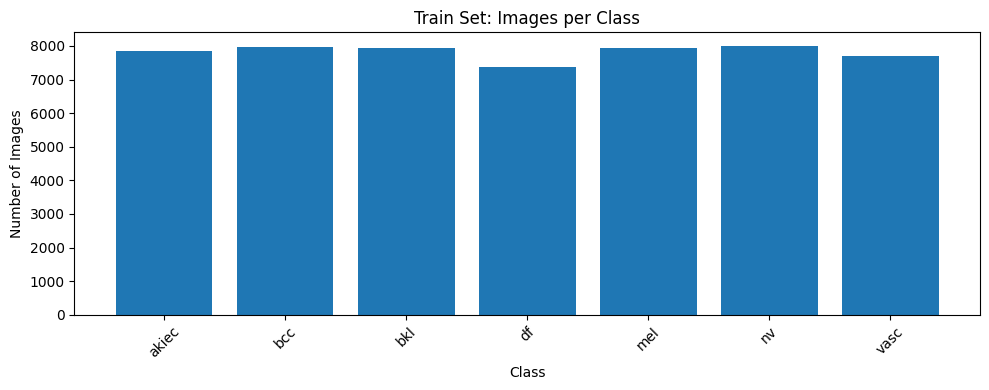

In [19]:
import matplotlib.pyplot as plt

classes = list(train_counts.keys())
values  = list(train_counts.values())

plt.figure(figsize=(10,4))
plt.bar(classes, values)
plt.title("Train Set: Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

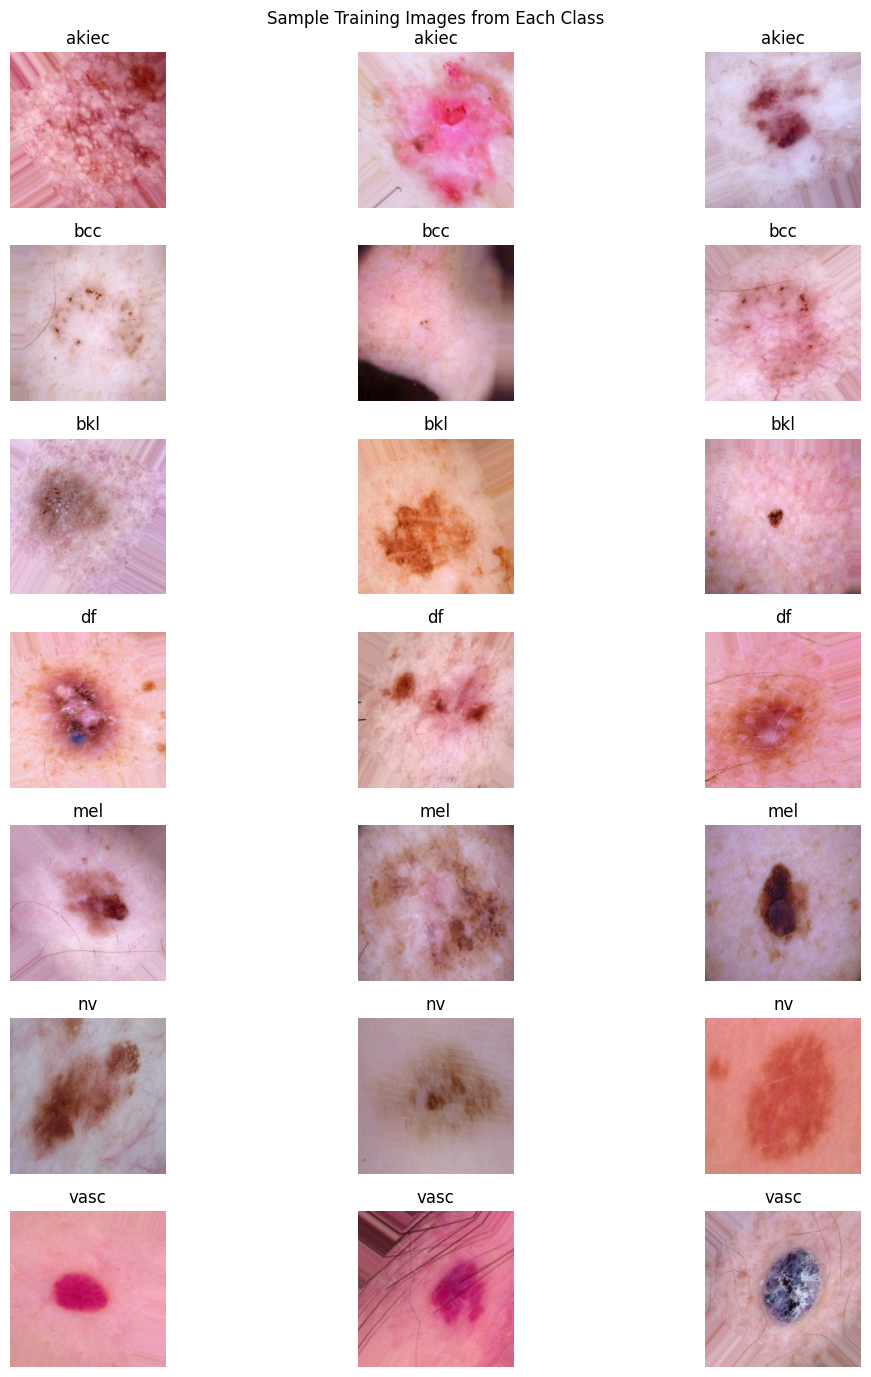

In [20]:
from tensorflow.keras.preprocessing.image import load_img

def show_samples(folder, per_class=3, img_size=(224,224)):
    classes = sorted(os.listdir(folder))
    plt.figure(figsize=(12, 2*len(classes)))
    plot_i = 1

    for cls in classes:
        cls_path = os.path.join(folder, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".png",".jpeg"))][:per_class]

        for img_name in imgs:
            img_path = os.path.join(cls_path, img_name)
            img = load_img(img_path, target_size=img_size)

            plt.subplot(len(classes), per_class, plot_i)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            plot_i += 1

    plt.suptitle("Sample Training Images from Each Class")
    plt.tight_layout()
    plt.show()

show_samples(TRAIN_DIR, per_class=3)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [22]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0,1]
    validation_split=0.2     # 80% train, 20% validation
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [24]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # 7 classes → one-hot encoding
    subset='training',
    shuffle=True
)

Found 43829 images belonging to 7 classes.


In [25]:
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 10953 images belonging to 7 classes.


In [26]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # IMPORTANT for confusion matrix later
)

Found 828 images belonging to 7 classes.


In [27]:
print("\n" + "="*50)
print("DATASET INFORMATION AFTER PREPROCESSING")
print("="*50)

print("Training samples   :", train_generator.samples)
print("Validation samples :", validation_generator.samples)
print("Test samples       :", test_generator.samples)

print("\nNumber of classes :", train_generator.num_classes)
print("Class indices     :", train_generator.class_indices)


DATASET INFORMATION AFTER PREPROCESSING
Training samples   : 43829
Validation samples : 10953
Test samples       : 828

Number of classes : 7
Class indices     : {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [28]:
images, labels = next(train_generator)

print("\nBatch Shape Verification")
print("="*50)
print("Image batch shape :", images.shape)
print("Label batch shape :", labels.shape)
print("Image data type   :", images.dtype)
print("Pixel range       :", images.min(), "to", images.max())


Batch Shape Verification
Image batch shape : (32, 224, 224, 3)
Label batch shape : (32, 7)
Image data type   : float32
Pixel range       : 0.0 to 1.0


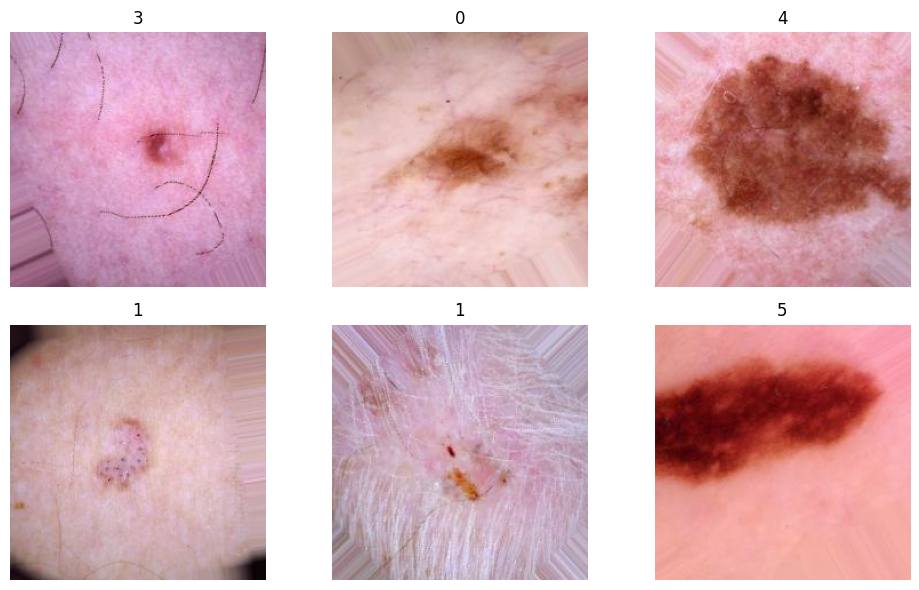

In [30]:
#Visualize one preprocessed batch
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis("off")

plt.tight_layout()
plt.show()